## <span style="color:blue;">STEP 1: DATA VISUALIZATION</span>

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = np.load('X.npy')
y = np.load('y.npy')  

print("X_features shape:", X.shape)
print("y shape:", y.shape)

X_features shape: (800, 1000, 501)
y shape: (800,)


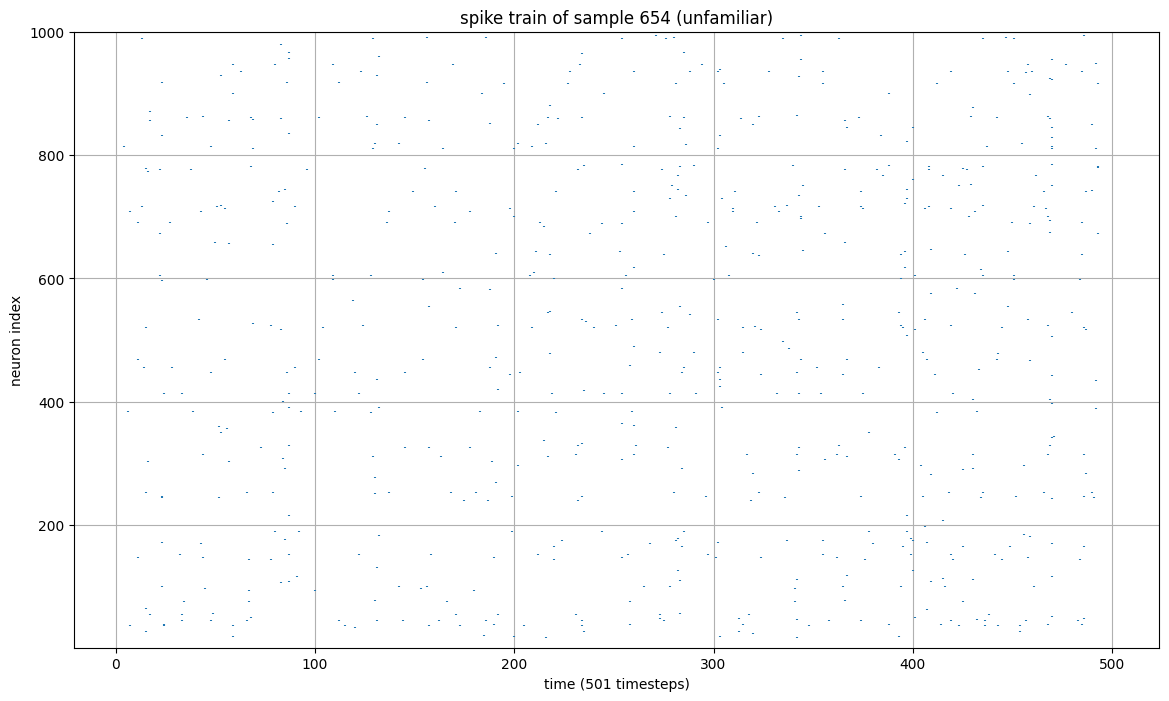

In [121]:
########################### look at one idividual sample #########################

sample_nr=654
sample = X[sample_nr] 
label = y[sample_nr]


plt.figure(figsize=(14, 8))

for neuron_idx in range(1000):
    spike_times = np.where(sample[neuron_idx] > 0)[0]# get the spike times for this neuron
    plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5) # plot the spikes

plt.title(f"spike train of sample {sample_nr} {'(familiar)' if label == 1 else '(unfamiliar)'}")
plt.xlabel("time (501 timesteps)")
plt.ylabel("neuron index")
plt.ylim(0.5, 1000.5)
plt.grid(True)
#plt.tight_layout()
plt.show()


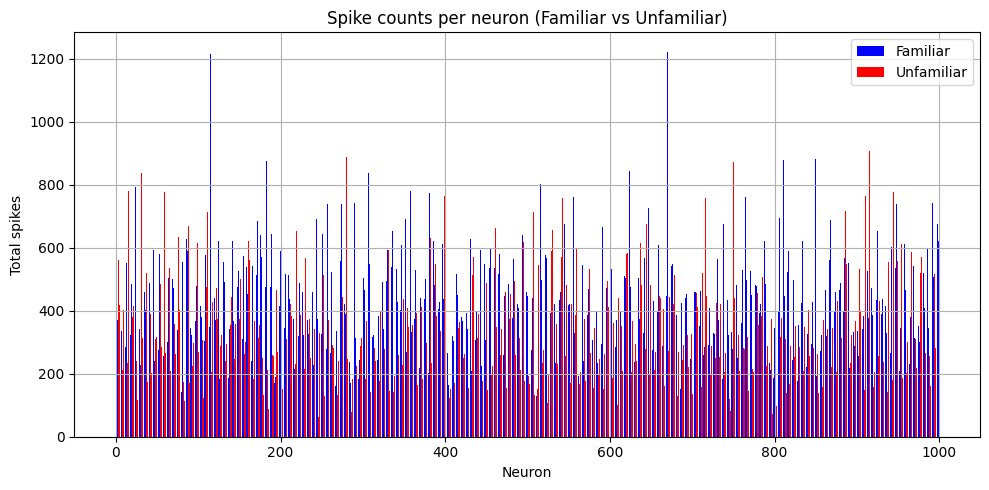

Neuron	Familiar	Unfamiliar	Diff (Unf - Fam)	% Diff (abs)
--------------------------------------------------------------------------------
83	391		113		-278			55.16
797	212		72		-140			49.30
917	482		174		-308			46.95
755	251		92		-159			46.36
451	390		148		-242			44.98


In [122]:
########################### IDENTIFY CRITICAL SINGLE NEURONS #########################

#familiar trials
X_fam = X[y == 1]
total_spikes_fam = np.sum(X_fam, axis=(0, 2))

#unfamiliar trials
X_unfam = X[y == 0]
total_spikes_unfam = np.sum(X_unfam, axis=(0, 2))

######################## Plot total spikes for familiar and unfamiliar trials #########################

n_neurons = X.shape[1]
x = np.arange(n_neurons)

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, total_spikes_fam, width=0.4, label="Familiar", color='blue')
plt.bar(x + 0.2, total_spikes_unfam, width=0.4, label="Unfamiliar", color='red')
plt.xlabel("Neuron")
plt.ylabel("Total spikes")
plt.title("Spike counts per neuron (Familiar vs Unfamiliar)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


########################### Print table of largest firing rate differences ###########


#percentage difference for each neuron
percent_diffs = []
for fam, unfam in zip(total_spikes_fam, total_spikes_unfam):
    diff = unfam - fam
    total = fam + unfam
    percent = (abs(diff) / total) * 100
    percent_diffs.append(percent)

#sort by descending percentage difference 
sorted_indices = np.argsort(percent_diffs)[::-1]

sorted_indices = sorted_indices[:5]  #keep only top 5

#table
print("Neuron\tFamiliar\tUnfamiliar\tDiff (Unf - Fam)\t% Diff (abs)")
print("-" * 80)
for i in sorted_indices:
    fam = total_spikes_fam[i]
    unfam = total_spikes_unfam[i]
    diff = unfam - fam
    total = fam + unfam
    ratio = (abs(diff) / total) * 100 if total != 0 else 0
    print(f"{i}\t{fam:.0f}\t\t{unfam:.0f}\t\t{diff:.0f}\t\t\t{ratio:.2f}")
    

### <span style="color:blue;">Observations</span>

I attempted to identify single neurons that may play a critical role in distinguishing familiar from unfamiliar trials by comparing total spike counts across the two groups. The neurons with the largest relative differences in spike activity were ranked, with the top neuron showing only a 55% difference between conditions while also not firing that often in general. And most neurons show much smaller differences.
This suggests that no single neuron is highly discriminative on its own, and that meaningful separation of familiar and unfamiliar trials likely happens at the population level, through combined activity patterns rather than isolated units.
I could still try to only focus on the most important neurons if i wanted the most simple model I can find, but for now I will not pursue the idea any further.


## <span style="color:blue;">STEP 2: DATA TRANSFORMATION</span>
### Neural coding techniques I'd like to try:

#### Rate Coding:
    -Compute Mean Firing Rate (average spikes per neuron over time).
    -Compute Fano Factor (variability of spike counts over time).

#### Temporal Coding:
    -Fast Fourier Transform(FFT).
        -Power in low-frequency bands (0–40 Hz).
        -Peak frequencies (frequency with highest power).

#### Population Coding:
    -Synchrony Variance (how much neurons fire together at each time point).
    -Population Sparseness (how many neurons are active at the same time, relative to the entire group)

In [123]:
def compute_features(X):
    n_samples = X.shape[0]
    features = []

    #just for clarification:
    #X.shape[0] = number of samples
    #X.shape[1] = number of neurons
    #X.shape[2] = number of timesteps

    for i in range(n_samples):
        
        x = X[i]

        #total spikes per neuron
        neuron_sums = np.sum(x, axis=1)

        #mean firing rate-----------------------
        firing_rate= neuron_sums /x.shape[1]
        mean_firing_rate = np.mean(firing_rate, axis=0)

        # hier vielleicht später noch firing rate pro timestep?

        #population sparseness-------------------
        if np.sum(neuron_sums) == 0:
            population_sparseness = 0
        else:
            numerator = (np.mean(neuron_sums))**2
            denominator = np.mean(neuron_sums**2)
            population_sparseness = numerator / denominator
        
        #synchrony variance---------------------
        total_spikes_per_time = np.sum(x, axis=0)
        synchrony_variance = np.var(total_spikes_per_time)

        #Fano Factor-----------------------------
        mean_spikes = np.mean(total_spikes_per_time)
        var_spikes = np.var(total_spikes_per_time)
        fano_factor = var_spikes / mean_spikes

        #fast forurier transormation----------------------------
        
        #apply fft
        fft = np.fft.fft(total_spikes_per_time)
        fft = fft[:len(fft)//2]#keep only positive frequencies

        #power-----------------------------------
        
        power = np.mean(np.abs(fft[:20]) ** 2)#only first 20 bins(40Hz)

        #peak frequency-------------------------

        #i remove the mean from the total spikes because else shows peak frequencies at 0 (DC component)
        total_spikes_per_time = total_spikes_per_time - np.mean(total_spikes_per_time)

        #remove everything above 40Hz (20 bins)
        fft = np.fft.fft(total_spikes_per_time[:20])

        #remove 0 hz component (DC component)
        fft[0] = 0

        #redo fft
        fft = fft[:len(fft)//2]

        #find the bin with the highest power
        peak_idx = np.argmax(np.abs(fft))

        #i could do this fancier but i am not even quite sure if 1 timestep is really 1ms
        #i just want the scale to be more interpretable
        peak_frequency = peak_idx * 2 #so 2 Hz per bin

        #----------------------------------------------------------------------------------------------

        #collect features in dict
        sample_features = {
            'mean_firing_rate': mean_firing_rate,
            'synchrony_variance': synchrony_variance,
            'power': power,
            'peak_frequency': peak_frequency,
            'fano_factor': fano_factor,
            'population_sparseness': population_sparseness,
        }

        features.append(sample_features)

    #make a dataframe so i dont get cofused with axis anymore
    features_df = pd.DataFrame(features)

    return features_df


## <span style="color:blue;">STEP 3: EXPLORATORY ANALYSIS</span>

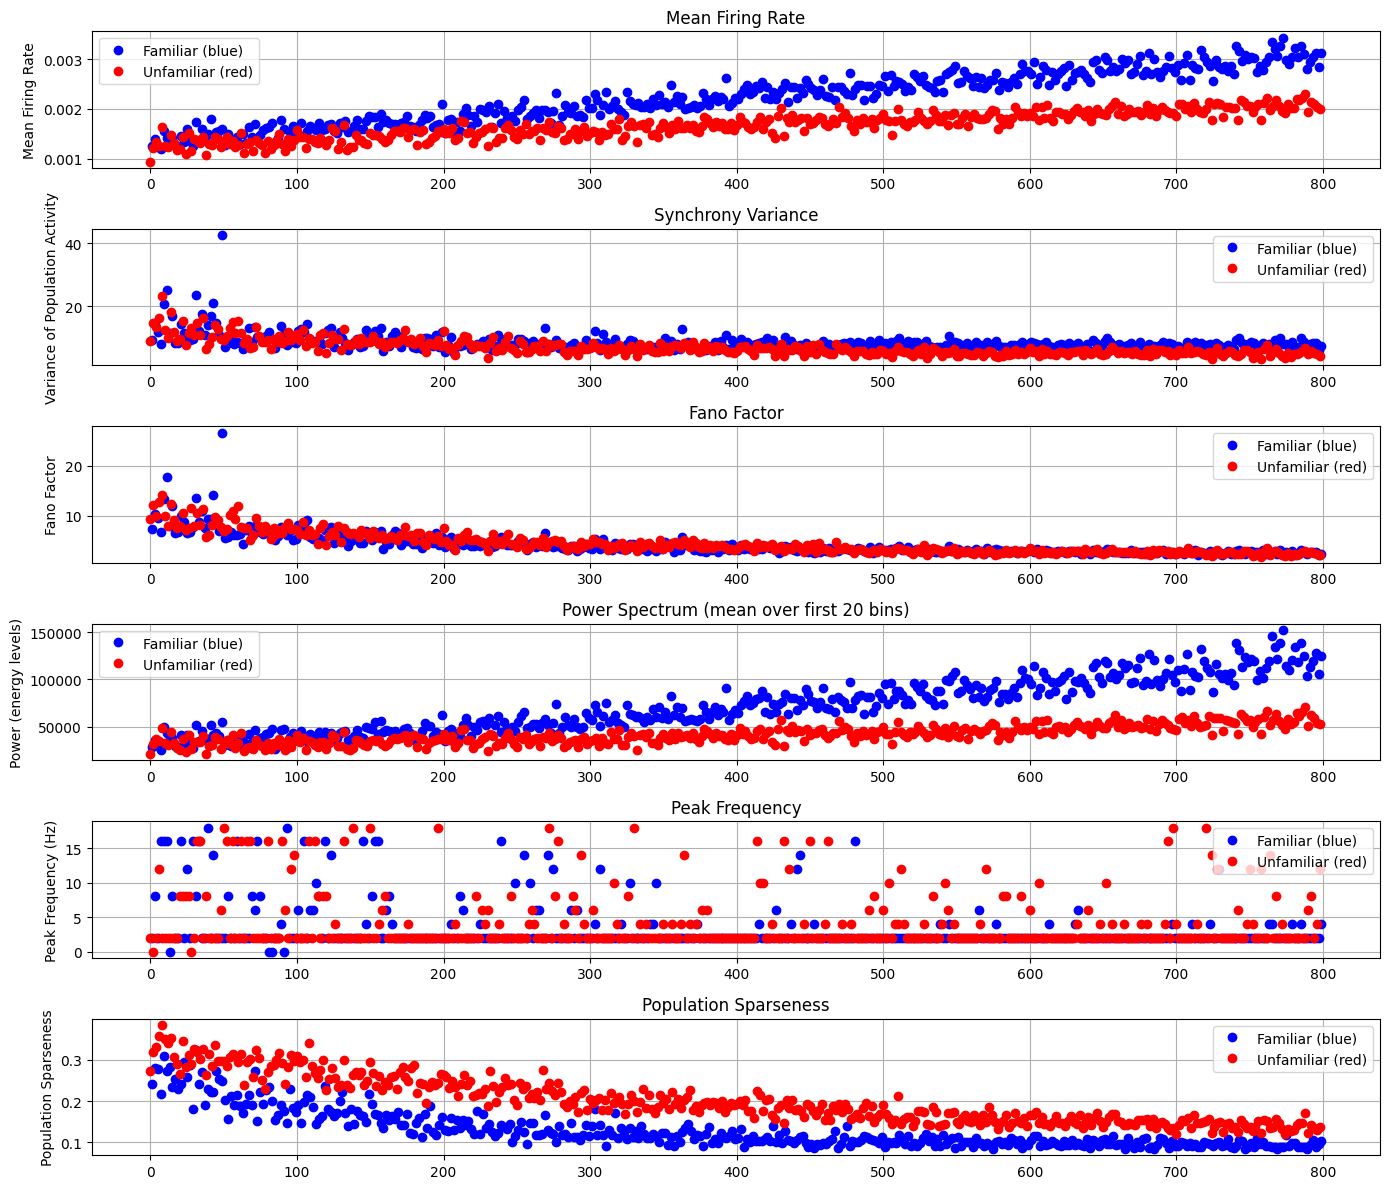

In [124]:
############### PLOT EVERYTHING ####################

features = compute_features(X)

nr_of_features=6

# print first 5 samples for quick check
#print(features.head())

plt.figure(figsize=(14, 12))

# 1. Mean Firing Rate
plt.subplot(nr_of_features, 1, 1)
plt.title("Mean Firing Rate")
plt.ylabel("Mean Firing Rate")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'mean_firing_rate'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'mean_firing_rate'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 2. Synchrony Variance
plt.subplot(nr_of_features, 1, 2)
plt.title("Synchrony Variance")
plt.ylabel("Variance of Population Activity")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'synchrony_variance'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'synchrony_variance'], 'ro', label='Unfamiliar (red)')
plt.legend()

#3. Fano Factor
plt.subplot(nr_of_features, 1, 3)
plt.title("Fano Factor")
plt.ylabel("Fano Factor")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'fano_factor'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'fano_factor'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 4. Power
plt.subplot(nr_of_features, 1, 4)
plt.title("Power Spectrum (mean over first 20 bins)")
plt.ylabel("Power (energy levels)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'power'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'power'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 5. Peak Frequency
plt.subplot(nr_of_features, 1, 5)
plt.title("Peak Frequency")
plt.ylabel("Peak Frequency (Hz)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'peak_frequency'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'peak_frequency'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 6. Population Sparseness
plt.subplot(nr_of_features, 1, 6)
plt.title("Population Sparseness")
plt.ylabel("Population Sparseness")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'population_sparseness'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'population_sparseness'], 'ro', label='Unfamiliar (red)')
plt.legend()



plt.tight_layout()
plt.show()




### <span style="color:blue;">Observations</span>

- The earlier samples are providing overall less secure evidence for being familiar/not familiar than the later ones.(Maybe the neurons became more tuned to the stimuli over time.)

- The mean firing rate, population sparseness and the power of lower frequencies seem to provide strong distinctions between the two groups. 

- Familiar examples show a higher firing rate than unfamiliar ones.

- Unfamilliar examples consistently show a higher population sparseness

- There might be a correlation between power and mean firing rate. -> redundancy?

- Fano factor and peak frequencies can probably be ignored as it is unclear from the plots that the two groups differ. Maybe from from the variance of population activity I could extract some information, but it looks weak.

#### Further explaination of the methods used

- The mean firing rate was calculated by summing all spikes across neurons and dividing by the total number of neuron-time combinations (number of neurons × number of timepoints).

- Instead of printing the fft in its raw form, I used power (|fft signal|^2) and looked at the mean of the first 20 bins. This should give a detailed enough view of lower frequencies, while ignoring the high frequency noise. Frequency per bin=1/T. 1/0.5sec (assuming one time point is one millisecond) would make one bin be equivalent to (roughly) 2Hz. So 20 bins cover ca. 40Hz ​ 

- Peak frequency: After removing the mean from the spike signal, I applied FFT and then identified the frequency bin with the highest value. At first, the frequencies looked very random but after removing all peaks above 40Hz (and zero ones), i identified that there seems to be a prominent and consistent 2Hz Signal in all the samples. I can not distinguish the two groups for now, but maybe this will be interesting later.

- To capture how synchronized the population activity is, I summed spikes across neurons at each timepoint and calculated the variance over time. A higher variance suggests more synchronous bursts of activity, while lower variance indicates more random firing.

- For each trial I computed the mean and variance of the summed spike counts across time bins. The Fano factor is the variance divided by the mean. It measures how regular or irregular the firing is.

- Population Sparseness: To measure how selectively the neurons responded during each trial, I computed population sparseness using the Vinje & Gallant formula. I summed the spikes per neuron, and then calculated the square of the mean divided by the mean of the squared responses. A value near 1 indicates that only a few neurons were active (sparse representation), while a value near 0 would indicate that many neurons fired together (dense).

In [125]:
###################### Further Inspect Power Spectrum ####################

power= features['power'].values

peak_freqs = features['peak_frequency'].values

#divide into familiar and unfamiliar
peak_fam = peak_freqs[y == 1]
peak_unfam = peak_freqs[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((peak_fam - np.mean(peak_fam)) ** 2))
std_unfam = np.sqrt(np.mean((peak_unfam - np.mean(peak_unfam)) ** 2))
std_peak = np.sqrt(np.mean((peak_freqs - np.mean(peak_freqs)) ** 2))

print(f"{'':<15}{'Mean(Hz)':>15}{'Std(Hz)':>15}")
print("_" * 50)
print(f"{'Familiar':<15}{np.mean(peak_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<15}{np.mean(peak_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Peak)':<15}{np.mean(peak_freqs):>15.2f}{std_peak:>15.2f}")

                      Mean(Hz)        Std(Hz)
__________________________________________________
Familiar                  3.37           3.51
Unfamiliar                4.16           4.18
Overall (Peak)            3.76           3.88


In [126]:
###################### Further Inspect Fano Factor ####################

fano = features['fano_factor'].values

#divide into familiar and unfamiliar
fano_fam = fano[y == 1]
fano_unfam = fano[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((fano_fam - np.mean(fano_fam)) ** 2))
std_unfam = np.sqrt(np.mean((fano_unfam - np.mean(fano_unfam)) ** 2))
std_fano = np.sqrt(np.mean((fano - np.mean(fano)) ** 2))

# print table
print(f"{''}{'Mean':>25}{'Std':>15}")
print("_" * 45)
print(f"{'Familiar':<10}{np.mean(fano_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<10}{np.mean(fano_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Fano)':<10}{np.mean(fano):>11.2f}{std_fano:>15.2f}")


                     Mean            Std
_____________________________________________
Familiar             4.15           2.30
Unfamiliar           4.35           2.16
Overall (Fano)       4.25           2.23


### <span style="color:blue;">Observations</span>

The Fano factor analysis shows similar variability across both groups, with basically no differences in their means and standard deviations. This suggests that trial-to-trial variability in population spiking was generally stable and does not strongly distinguish between familiar and unfamiliar.

The power spectrum analysis shows that unfamiliar trials have a mean peak frequency of 4.16 Hz,familiar trials average 3.37 Hz. This suggests that unfamiliar stimuli tend to cause slightly faster oscillating neural activity, which may reflect increased attentional engagement or the processing of novel information.

I will now visualize the distributions of the extracted features using histograms. 




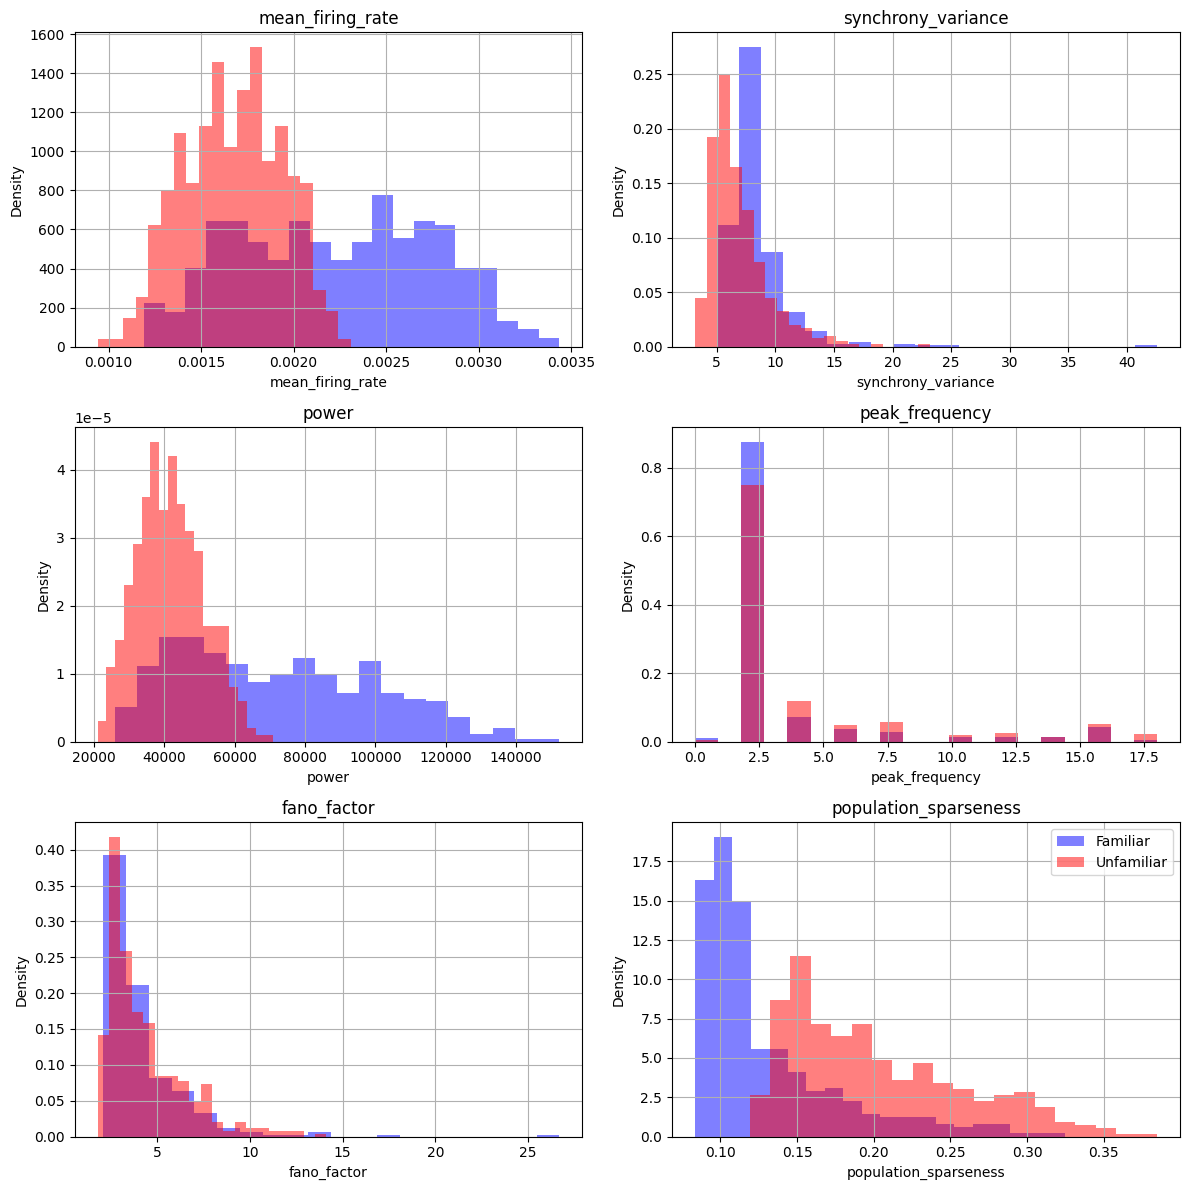

In [127]:
######################## Feature Distributions Histograms ######################## 

def plot_feature_distributions(features, y, feature_list):
    n_features = len(feature_list)
    n_cols = 2 #how many plots per row
    n_rows = (n_features + n_cols - 1) // n_cols #compute rows automatically B)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten() #flatten to make it easy to index

    for idx, feature_name in enumerate(feature_list):
        fam_values = features.loc[y == 1, feature_name].values
        unfam_values = features.loc[y == 0, feature_name].values

        ax = axes[idx]
        ax.hist(fam_values, bins=20, alpha=0.5, label='Familiar', color='blue', density=True)# density=True here the histogram gets normalized
        ax.hist(unfam_values, bins=20, alpha=0.5, label='Unfamiliar', color='red', density=True)
        ax.set_title(f"{feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Density")
        ax.grid(True)

    #hide empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.legend()
    plt.show()


feature_list = ['mean_firing_rate', 'synchrony_variance', 'power', 'peak_frequency', 'fano_factor', 'population_sparseness']

plot_feature_distributions(features, y, feature_list)



I used overlaid histograms normalized to density.
Histograms are a more intuitive visualization of the full distribution of feature values.
The focus is on shape and spread, not total counts.

### <span style="color:blue;">Observations</span>

- There remains overlap between the groups, so perfect classification based on any single feature alone is probably not possible.

In [128]:
######################## Compute Cohen's d ########################

def cohen_d(x, y):
    #calculate cohen's d for two samples
    mean_x, mean_y = np.mean(x), np.mean(y)# calculate means
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)# calculate variances
    pooled_std = np.sqrt((var_x + var_y) / 2)# pooled standard deviation
    d = (mean_x - mean_y) / pooled_std#
    return d


print(f"{'Feature':<25}{'Cohen´s d':>10}")
print("_" * 40)

#loop over all features 
for feature_name in feature_list:
    fam_values = features.loc[y == 1, feature_name].values
    unfam_values = features.loc[y == 0, feature_name].values

    d = cohen_d(fam_values, unfam_values)
    print(f"{feature_name:<25}{d:>10.2f}")

Feature                   Cohen´s d
________________________________________
mean_firing_rate               1.36
synchrony_variance             0.59
power                          1.46
peak_frequency                -0.20
fano_factor                   -0.09
population_sparseness         -1.37


Cohen’s d measures the difference between two group means divided by their pooled standard deviation.
I use it to quantify how different two groups are.
It gives a standardized, numerical measure of the separation between familiar and unfamiliar trials. High values mean the two groups are well separated.

In [129]:
def kl_divergence(p, q, bins=50):
    #histogram binning with density=True to normalize
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    #to avoid division by zero
    epsilon = 1e-10
    p_hist = p_hist + epsilon
    q_hist = q_hist + epsilon

    #normalize histograms
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)

    # sum P(x) * log(P(x) /Q(x))
    kl = np.sum(p_hist * np.log(p_hist / q_hist))

    return kl

print(f"{'Feature':<25}{'KL Divergence':>15}")
print("_" * 45)

for feature_name in feature_list:
    fam_values = features.loc[y == 1, feature_name].values
    unfam_values = features.loc[y == 0, feature_name].values

    kl = kl_divergence(fam_values, unfam_values)
    print(f"{feature_name:<25}{kl:>15.2f}")



Feature                    KL Divergence
_____________________________________________
mean_firing_rate                   13.66
synchrony_variance                  0.52
power                               5.30
peak_frequency                      0.04
fano_factor                         0.25
population_sparseness              14.73




### <span style="color:blue;">Observations</span>

- As expected, mean firing rate, population sparseness and low-frequency power show strong separation between familiar and unfamiliar trials. Synchrony variance shows moderate separation, peak frequency and fano factor little to none.

- Population Sparseness, Mean firing rate and power remain the three most promising measurements.

#### <span style="color:blue;">Justification</span>

Cohen’s d is useful for quantifying the difference in means between two groups, it assumes that the data is normally distributed and only reflects mean shift relative to spread.

KL divergence however, compares the entire shape of the distributions, so it is more appropriate when the goal is to detect asymmetric, non-gaussian differences between classes (as it is the case in the data).
Since classification models depend on how distributions overlap, KL divergence provides a more informative measure.

### <span style="color:blue;">Intermediate Conclusion</span>

I analyzed how much the neurons fire, how rhythmically they fire, and how much they fire together. I assessed which measurements are reliable. But now, they are still reliant on the sample-index-x-axis. Since a random new sample is unlikely to come with data about how far the experiment has progressed at the time of measurement, I should not include it in the classifier.

Now I can start to combine my best estimators in a model:

## <span style="color:blue;">STEP 4: MODEL TRAINING AND CLASSIFICATION</span>

I use Logistic Regression as the classification model.  
It is simple, fast, interpretable, and suitable for binary(output) classification problems like this one. 
Since we have a relatively small number of features and balanced classes, Logistic Regression is a reasonable first choice. For Being able to plot the regression line, I start by only taking two of my three most distinguishing features.

In [130]:

import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


############################# Logistic Regression ###############################


selected_features = ['mean_firing_rate', 'power'] 
#selected_features = features.columns.tolist()

X_selected_features = features[selected_features].values
y = y

#standardize features
X_mean = X_selected_features.mean(axis=0)
X_std = X_selected_features.std(axis=0)
X_scaled = (X_selected_features - X_mean) / X_std


################ Cross-Validation ###############

clf = LogisticRegression(max_iter=1000, random_state=42)

#10-fold stratified CV
cv_scores = cross_val_score(
    clf,
    X_scaled, #scaled features
    y, #target variabke
    cv=10,
    scoring='accuracy',
    n_jobs=-1 
)

print("Accuracy per Fold:", cv_scores)
print(f"Average CV-Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

###################################################

#split training and test (80/20)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#train the model
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predict on the test set
y_pred = model.predict(X_test)


Accuracy per Fold: [0.5375 0.5375 0.575  0.6875 0.925  0.9875 0.9875 0.9375 0.825  0.65  ]
Average CV-Accuracy: 0.765 ± 0.178


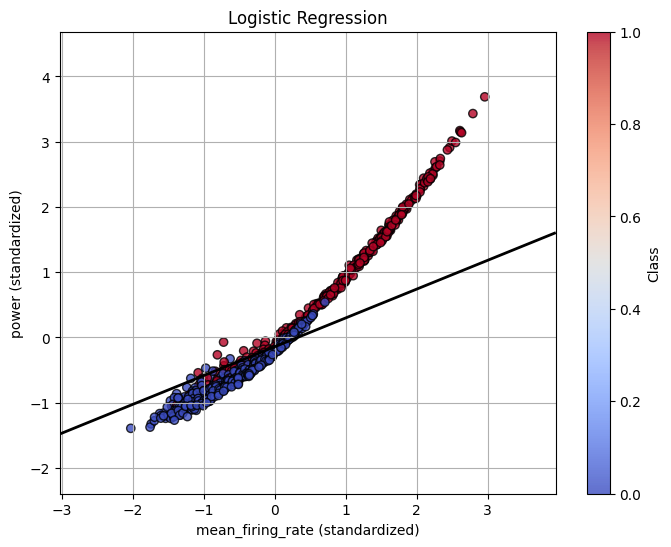


Accuracy: 0.7875

Bias (w0): 0.6793

Feature                      Weight
________________________________________
mean_firing_rate            -2.0692
power                        4.6843

Confusion Matrix:
[[77 12]
 [22 49]]


In [131]:

##################### Plot Logistic Regression ###########################

#create grid
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
#predict probabilities
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

#plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap="coolwarm", edgecolors='k', alpha=0.8)
plt.contour(xx, yy, probs, levels=[0.5], linewidths=2, colors='black')
plt.xlabel(selected_features[0] + " (standardized)")
plt.ylabel(selected_features[1] + " (standardized)")
plt.title("Logistic Regression")
plt.grid(True)
plt.colorbar(scatter, label="Class")
plt.show()

########################### Evaluation  ###########################################


#accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

#bias 
bias= model.intercept_[0]
print(f"\nBias (w0): {bias:.4f}")

#weights table
print(f"\n{'Feature':<25}{'Weight':>10}")
print("_" * 40)

for feature_name, weight in zip(selected_features, model.coef_[0]):
    print(f"{feature_name:<25}{weight:>10.4f}")

#confusion matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

These two features do not suffice to make an acceptable model (only 79% Accuracy)

(Average CV-Accuracy: 0.765 ± 0.178)

I will now use logistic regression with all the relevant features and see how much it will improve.

In [ ]:
###################### Logistic Regression on all features ############################


#selected_features = features.columns.tolist()
selected_features = [ 'mean_firing_rate', 'synchrony_variance', 'power', 'population_sparseness'] 

# after playing around with the features, i realized that the peak frequency and fano factor 
# can be removed without loss of accuracy.

X_features = features[selected_features].values
y = y

#train/test split (80/20)
X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X_features, y, test_size=0.2, random_state=42)

scaler   = preprocessing.StandardScaler().fit(X_train_raw)

################ Cross-Validation ###############

clf = LogisticRegression(max_iter=1000, random_state=42)

#10-fold stratified CV
cv_scores = cross_val_score(
    clf,
    X_train, #scaled features
    y_train, #target variabke
    cv=10,
    scoring='accuracy',
    n_jobs=-1 
)

print("Accuracy per Fold:", cv_scores)
print(f"Average CV-Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

###################################################

X_train  = scaler.transform(X_train_raw)
X_test   = scaler.transform(X_test_raw)

#train
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#predict test set
y_pred_logistic_regression = model.predict(X_test)

C:\Users\Silas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy per Fold: [0.921875 0.96875  1.       0.9375   0.953125 0.921875 0.9375   1.
 0.9375   0.96875 ]
Average CV-Accuracy: 0.955 ± 0.027


## <span style="color:blue;">STEP 5: MODEL EVALUATION</span>

I chose accuracy as the primary evaluation metric because the dataset is balanced, with an equal number of familiar and unfamiliar trials.
Accuracy is appropriate when both classes are equally important and class imbalance is not a concern.

If the classes were highly imbalanced (many more familiar than unfamiliar trials), then metrics like the F1-score would be preferred.
The F1-score balances precision and recall, so it is better suited for situations where correctly identifying the minority class is important.


In [133]:
########################### Evaluation  ###########################################

#accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_logistic_regression)
print(f"\nAccuracy: {accuracy:.4f}")

#bias 
bias= model.intercept_[0]
print(f"\nBias (w0): {bias:.4f}")

#weights table
print(f"\n{'Feature':<25}{'Weight':>10}")
print("_" * 40)

for feature_name, weight in zip(selected_features, model.coef_[0]):
    print(f"{feature_name:<25}{weight:>10.4f}")

#confusion matrix
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_logistic_regression),'\n')

#print(metrics.classification_report(y_test, y_pred))


Accuracy: 0.9625

Bias (w0): 0.3938

Feature                      Weight
________________________________________
mean_firing_rate            -2.0746
synchrony_variance           3.3767
power                        1.3755
population_sparseness       -4.8202

Confusion Matrix:
[[88  1]
 [ 5 66]] 



### <span style="color:blue;">Observations</span>


The model achieves an acceptable accuracy of 96.25%. (Average CV-Accuracy: 0.955 ± 0.027)
The confusion matrix shows that both classes are classified well, with very few false positives or false negatives.

Synchrony variance and population sparseness have the largest weights, so they contribute the most to the decision boundary.
Population sparseness has a strong negative weight, so trials with dense neural activity are more likely to be classified as unfamiliar.

### <span style="color:blue;">Logistic Regression Decision Function

$$
P(y = 1 \mid x) = \sigma\left(
\begin{aligned}
&w_0 \\
&+ w_1 \cdot \text{mean\_firing\_rate} \\
&+ w_2 \cdot \text{synchrony\_variance} \\
&+ w_3 \cdot \text{power} \\
&+ w_4 \cdot \text{population\_sparseness}
\end{aligned}
\right)
$$

$$( \sigma(x) = \frac{1}{1 + e^{-x}} )$$ 



So plugging in the values we get:

$$
P(y = 1 \mid x) = \sigma\left(
\begin{aligned}
&0.3193 \\
&- 1.7820 \cdot \text{mean\_firing\_rate} \\
&+ 3.4514 \cdot \text{synchrony\_variance} \\
&+ 1.2990 \cdot \text{power} \\
&- 4.2487 \cdot \text{population\_sparseness}
\end{aligned}
\right)
$$


$$ P(y = 1 \mid x) > 0.5 \Rightarrow Unfamiliar\\ $$
$$ P(y = 1 \mid x) < 0.5 \Rightarrow Familiar\\ $$



## <span style="color:blue;">STEP 6: MODEL COMPARISON</span>

### Models I would like to try, apart from Logistic Regression:

Logistic Regression with polynomial features

k-Nearest Neighbors (k-NN)
- classifies samples based on the majority class among their k closest neighbors
- good for: data with clear local clusters and nonlinear boundaries

Linear Discriminant Analysis (LDA)
- projects data onto a lower-dimensional space that best separates the classes
- good for well-separated classes and when features follow Gaussian distributions

Random Forest
- based on many decision trees 
- good for capturing nonlinear patterns
- less interpretable and slower to train than linear models

Regularized Least Squares (Ridge Regression) 
- linear  
- L2 regularization to prevent overfitting
- good for high-dimensional data and collinear features



In [134]:
############################ Preprocessing ##############################
#all the models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

X = features.values

#split into train and test set (80/20)
X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler   = preprocessing.StandardScaler().fit(X_train_raw)
X_train  = scaler.transform(X_train_raw)
X_test   = scaler.transform(X_test_raw)

In [135]:
########### Polynomial Logistic Regression with all  features ########################

#generate polynomial features
poly = preprocessing.PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#standardize
scaler = preprocessing.StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

#train
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train_poly, y_train)

#predict
y_pred_added_poly = model.predict(X_test_poly)

In [136]:
######################## OTHER MODELS ##############################################


#------------------- K-Nearest Neighbors----------------

#train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

#predict and evaluate
y_pred_knn = knn.predict(X_test)

#------------------- LDA -------------------

#train
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)

#predict
y_pred_lda = lda.predict(X_test)

#------------------- Random Forest -------------------

#train
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

#predict
y_pred_rf = forest.predict(X_test)


#------------------- Regularized Least Squares -------------------

#train
ridge = Ridge(alpha=1.0) #regularization strength alpha
ridge.fit(X_train, y_train)

#predict threshold
y_pred_scores = ridge.predict(X_test)
y_pred_ridge = (y_pred_scores >= 0.5).astype(int)

In [137]:
def evaluate_models(models_info, sort_by="Accuracy"):
    
    model_names = []
    accuracies = []
    f1_scores = []
    precision_f = []
    precision_uf = []

    for name, y_true, y_pred in models_info:
        model_names.append(name)
        accuracies.append(metrics.accuracy_score(y_true, y_pred))
        f1_scores.append(metrics.f1_score(y_true, y_pred))
        precision_f.append(metrics.precision_score(y_true, y_pred, pos_label=1))
        precision_uf.append(metrics.precision_score(y_true, y_pred, pos_label=0))

    results_df = pd.DataFrame({
        "Model": model_names,
        "Accuracy": accuracies,
        "F1 Score": f1_scores,
        "Precision F": precision_f,
        "Precision UF": precision_uf
    })

    return results_df.sort_values(sort_by, ascending=False).reset_index(drop=True)


models_info = [
    ("Logistic Regression", y_test, y_pred_logistic_regression),
    ("Poly Logistic Regression", y_test, y_pred_added_poly),
    ("k-NN", y_test, y_pred_knn),
    ("LDA", y_test, y_pred_lda),
    ("Random Forest", y_test, y_pred_rf),
    ("Ridge", y_test, y_pred_ridge)
]

results_df = evaluate_models(models_info)
display(results_df)

,Model,Accuracy,F1 Score,Precision F,Precision UF
0,k-NN,0.96875,0.964029,0.985294,0.956522
1,LDA,0.96875,0.963504,1.000000,0.946809
2,Ridge,0.96875,0.963504,1.000000,0.946809
3,Logistic Regression,0.96250,0.956522,0.985075,0.946237
4,Poly Logistic Regression,0.96250,0.957746,0.957746,0.966292
5,Random Forest,0.95625,0.948905,0.984848,0.936170


!!!
The Logistic Regression model was optimized with a selected subset of features. These features were chosen because they performed well in that specific model. All other models were evaluated using the same feature set without tailoring it to their individual strengths. Also the same is the case for hyperparameters. (For exapmle n_neighbors in k-NN, which now would just be the default value, not the optimal one.)

This is a potential **bias**

For a more a more comprehensive analysis, I could tune each model with its own optimal set of features. 
I could use Bayesian optimization to find the best parameters for each model.
I will start with selection of the features.

In [143]:
#################################### BRUTE FORCE FEATURE SELECTION ####################################

from itertools import combinations

def find_best_combo(features_df, y_array, evaluator_func, min_features=2):
  
    best_accuracy = 0
    best_combo = None

    feature_names = features_df.columns.tolist()

    for r in range(min_features, len(feature_names) + 1):# loop over all combinations of features
        for combo in combinations(feature_names, r): # loop over all combinations 
            X_subset = features_df[list(combo)].values
            try:
                acc = evaluator_func(X_subset, y_array)
                if acc > best_accuracy:# check if current accuracy better than best accuracy
                    best_accuracy = acc
                    best_combo = combo# update
            except Exception as e:
                continue

    return best_combo, best_accuracy


In [144]:
################################# Build functions for every model ##############################


def evaluate_random_forest(X, y):
    X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=42)

    scaler   = preprocessing.StandardScaler().fit(X_train_raw)
    X_train  = scaler.transform(X_train_raw)
    X_test   = scaler.transform(X_test_raw)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)

def evaluate_lda(X, y):
    X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=42)

    scaler   = preprocessing.StandardScaler().fit(X_train_raw)
    X_train  = scaler.transform(X_train_raw)
    X_test   = scaler.transform(X_test_raw)

    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)

def evaluate_knn(X, y):
    X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=42)

    scaler   = preprocessing.StandardScaler().fit(X_train_raw)
    X_train  = scaler.transform(X_train_raw)
    X_test   = scaler.transform(X_test_raw)

    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)

def evaluate_ridge(X, y):
    X_train_raw, X_test_raw, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=42)

    scaler   = preprocessing.StandardScaler().fit(X_train_raw)
    X_train  = scaler.transform(X_train_raw)
    X_test   = scaler.transform(X_test_raw)
    
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred_scores = model.predict(X_test)
    y_pred = (y_pred_scores >= 0.5).astype(int)
    return metrics.accuracy_score(y_test, y_pred)

In [145]:
###################### Find best feature combinations for each model ########################

model_functions = ["evaluate_random_forest", "evaluate_lda", "evaluate_knn", "evaluate_ridge"]

for model_func in model_functions:
    print(f"\nOptimal feature combo for {model_func}:")
    best_combo, best_acc = find_best_combo(features, y, eval(model_func))
    print("Best combo:", best_combo)
    print("Accuracy:", best_acc)




Optimal feature combo for evaluate_random_forest:
Best combo: ('synchrony_variance', 'power', 'peak_frequency', 'fano_factor', 'population_sparseness')
Accuracy: 0.971875

Optimal feature combo for evaluate_lda:
Best combo: ('mean_firing_rate', 'synchrony_variance', 'population_sparseness')
Accuracy: 0.965625

Optimal feature combo for evaluate_knn:
Best combo: ('synchrony_variance', 'fano_factor', 'population_sparseness')
Accuracy: 0.959375

Optimal feature combo for evaluate_ridge:
Best combo: ('mean_firing_rate', 'synchrony_variance', 'population_sparseness')
Accuracy: 0.965625


In [141]:
######################## RERUN EVERY MODEL WITH BEST FEATURES  ########################

best_feature_sets = {
    "RF": ['synchrony_variance', 'power', 'peak_frequency', 'fano_factor', 'population_sparseness'],
    "LDA": ['mean_firing_rate', 'synchrony_variance', 'population_sparseness'],
    "k-NN": ['power', 'fano_factor', 'population_sparseness'],
    "Ridge": ['mean_firing_rate', 'synchrony_variance', 'population_sparseness']
}

#RF
X_rf = features[best_feature_sets["RF"]].values
X_scaled_rf = scaler.fit_transform(X_rf)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = model_selection.train_test_split(X_scaled_rf, y, test_size=0.2, random_state=42)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = model_rf.predict(X_test_rf)

#LDA
X_lda = features[best_feature_sets["LDA"]].values
X_scaled_lda = scaler.fit_transform(X_lda)
X_train_lda, X_test_lda, y_train_lda, y_test_lda = model_selection.train_test_split(X_scaled_lda, y, test_size=0.2, random_state=42)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_train_lda, y_train_lda)
y_pred_lda = model_lda.predict(X_test_lda)

#k-NN
X_knn = features[best_feature_sets["k-NN"]].values
X_scaled_knn = scaler.fit_transform(X_knn)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = model_selection.train_test_split(X_scaled_knn, y, test_size=0.2, random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=6)
model_knn.fit(X_train_knn, y_train_knn)
y_pred_knn = model_knn.predict(X_test_knn)

#Ridge
X_ridge = features[best_feature_sets["Ridge"]].values
X_scaled_ridge = scaler.fit_transform(X_ridge)
X_train_ridge, X_test_ridge, y_train_ridge, y_test_ridge = model_selection.train_test_split(X_scaled_ridge, y, test_size=0.2, random_state=42)
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_ridge, y_train_ridge)
y_pred_scores_ridge = model_ridge.predict(X_test_ridge)
y_pred_ridge = (y_pred_scores_ridge >= 0.5).astype(int)

In [48]:
############################## FINAL EVALUATION ##############################
models_info = [
    ("Logistic Regression", y_test, y_pred_logistic_regression),
    ("Poly Logistic Regression", y_test, y_pred_added_poly),
    ("k-NN", y_test, y_pred_knn),
    ("LDA", y_test, y_pred_lda),
    ("Random Forest", y_test, y_pred_rf),
    ("Ridge", y_test, y_pred_ridge)
]

results_df = evaluate_models(models_info)
display(results_df)

,Model,Accuracy,F1 Score,Precision F,Precision UF
0,Random Forest,0.971875,0.969900,0.986395,0.959538
1,Poly Logistic Regression,0.968750,0.966887,0.973333,0.964706
2,LDA,0.965625,0.962963,0.986207,0.948571
3,Ridge,0.965625,0.962963,0.986207,0.948571
4,Logistic Regression,0.962500,0.959732,0.979452,0.948276
5,k-NN,0.959375,0.955631,0.992908,0.932961


### <span style="color:blue;">Observations</span>

It turns out that Random Forest outperforms all other models.
It made best use of all the features I implemented.
It learned the class distinctions effectively, and it captured subtle, non-linear patterns

Polynomial Logistic Regression is in the second place showing that non-linear decision boundaries help, but not quite as much as Random Forest’s full flexibility

LDA and Ridge seem to have a lot in common.

The still strong performance of Logistic Regression suggests that the data is largely linearly separable 
But there are subtle non-linear patterns that linear models can't fully capture

Still I maybe should have chosen the Random Forest Model. Logistic Regression performed well but its linear nature has limited its ability to exploit the structure in the data. 
Also some feature redundancy was evident in the features with several partially overlapping in the information they conveyed. Random Forest is naturally robust to redundancy, as it can ignore irrelevant or less informative features during tree construction.



In [284]:
!jupyter nbconvert --to html main.ipynb

[NbConvertApp] Converting notebook main.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1022498 bytes to main.html
